In [1]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots

In [2]:
rng = Xoshiro(0)
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))

2×30 Matrix{Float32}:
 2.0  1.9465    1.74178  1.23837  0.577127  …  1.40688   1.37023   1.29214
 0.0  0.798832  1.46473  1.80877  1.86465      0.451377  0.728699  0.972102

In [3]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#11),
        layer_2 = Dense(2 => 50, tanh_fast),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states.

In [4]:
println(prob_neuralode)
println(size(prob_neuralode(u0, p, st)[1]))

NeuralODE{Chain{@NamedTuple{layer_1::WrappedFunction{:direct_call, var"#11#12"}, layer_2::Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}, Tuple{Float32, Float32}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Pairs{Symbol, StepRangeLen{Float32, Float64, Float64, Int64}, Tuple{Symbol}, @NamedTuple{saveat::StepRangeLen{Float32, Float64, Float64, Int64}}}}(Chain{@NamedTuple{layer_1::WrappedFunction{:direct_call, var"#11#12"}, layer_2::Dense{true, typeof(tanh_fast), typeof(glorot_uniform), typeof(zeros32)}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}}((layer_1 = WrappedFunction(#11), layer_2 = Dense(2 => 50, tanh_fast), layer_3 = Dense(50 => 2)), nothing), (0.0f0, 1.5f0), (Tsit5(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),),), Bas

In [5]:
function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1]) # return only the solution, not the tspan
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

In [6]:
println(p)

(layer_1 = NamedTuple(), layer_2 = (weight = Float32[-0.2998639 0.25123218; -0.030409519 -0.07782018; 0.27917817 0.1324156; 0.032366645 -0.17954215; 0.12575795 0.30252594; 0.18570715 0.010315689; -0.26312527 -0.206007; 0.29931843 0.08448705; -0.060168833 0.22011122; -0.3195415 0.10445179; 0.27317983 -0.30395904; 0.16776465 0.27745458; -0.18548484 -0.19495438; 0.16766816 0.04767707; -0.14038186 0.2109964; 0.3238334 -0.06240917; 0.2529682 -0.035720997; -0.11594381 0.01833508; 0.07807367 -0.25980347; 0.116851434 -0.25139844; 0.124044314 -0.13928136; -0.27192438 -0.3222633; -0.068366475 0.04818344; -0.18333468 0.2988623; 0.18498936 0.08296422; 0.08917113 0.06853266; -0.109810196 -0.12959029; -0.27402103 -0.18765913; 0.2153094 -0.2131076; 0.13452137 -0.1570576; 2.9965104f-6 -0.12063185; -0.020206157 -0.062439054; 0.2502662 0.26961833; -0.26164815 0.16358416; -0.026455136 0.17291245; 0.329365 0.2537442; 0.28846782 -0.22040568; 0.15676928 0.17583649; -0.08107945 0.123558514; -0.25997135 0.287

In [14]:
println(ode_data[1,:])
println(size(ode_data))

Float32[2.0, 1.9465026, 1.7417797, 1.2383717, 0.57712656, -0.079900764, -0.701096, -1.2428561, -1.5910548, -1.7101355, -1.7087544, -1.6840465, -1.649531, -1.5526896, -1.3280721, -0.98086625, -0.57763726, -0.17339568, 0.21682541, 0.59058577, 0.93188167, 1.2036257, 1.3721341, 1.442406, 1.4524038, 1.4403232, 1.4251611, 1.4068803, 1.3702303, 1.2921442]
(2, 30)


In [7]:
# Callback function to observe training
callback = function (p, l, pred; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...) #loss_neuralode output a tuple of loss and prediction

340.37155


false

In [8]:
println(typeof(pinit))

ComponentVector{Float32, Vector{Float32}, Tuple{Axis{(layer_1 = 1:0, layer_2 = ViewAxis(1:150, Axis(weight = ViewAxis(1:100, ShapedAxis((50, 2))), bias = ViewAxis(101:150, ShapedAxis((50, 1))))), layer_3 = ViewAxis(151:252, Axis(weight = ViewAxis(1:100, ShapedAxis((2, 50))), bias = ViewAxis(101:102, ShapedAxis((2, 1))))))}}}


In [9]:
# Train using the Adam optimizer
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x,p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit) #function, initial guess

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 300)

340.37155
152.8354
110.04178
107.69142
108.5716
104.79025
99.486855
95.55531
93.3443
92.08124
91.30223
90.79349
90.35039
89.75757
88.85644
87.56676
85.867775
83.81379
81.54606
79.14193
76.39014
72.874535
68.58205
64.985085
59.893852
55.011814
50.967487
46.116035
41.01922
36.104713
31.865807
29.424074
28.318403
28.051598
29.069502
27.373592
27.920654
27.057306
26.294933
26.629393
25.349575
25.196772
24.086496
22.895687
22.329235
20.323795
19.174677
17.634272
16.400812
15.278134
14.141896
13.3059845
12.439932
11.823291
10.963845
10.565492
9.731016
9.404444
8.809566
8.722075
8.315342
7.735649
7.7108917
7.2534976
7.1356544
6.9217296
6.6956196
6.6017127
6.307573
6.1283755
6.0320444
5.741144
5.619826
5.4034576
5.2176347
5.069714
4.976581
4.804568
4.7556705
4.651239
4.490286
4.409822
4.2689557
4.295745
4.2102685
4.0782814
4.115407
4.005614
3.9877112
3.8837714
3.8582036
3.8702655
3.7599258
3.75054
3.7247016
3.5969105
3.6866686
3.5500698
3.6844869
3.6456249
3.3988237
3.5267189
3.3408902
3.33347

retcode: Default
u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[-0.16178022 0.077871956; 0.22389893 -0.46694577; … ; -0.3833352 -1.3603525; -0.1629136 -0.009491738], bias = Float32[-0.0025992806; 0.49388117; … ; -0.4029319; 0.0026481887;;]), layer_3 = (weight = Float32[-0.0817732 0.5815959 … -0.1747779 0.12725373; -0.72357064 0.60050833 … 0.42849812 -0.8184932], bias = Float32[-0.5761158; -0.1323977;;]))

In [10]:
# Retrain using the LBFGS optimizer
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(optprob2, Optim.BFGS(; initial_stepnorm = 0.01);
    callback = callback, allow_f_increases = false)

0.20931251
0.20686495
0.20558761
0.1953642
0.19125141
0.16940227
0.15151182
0.13461028
0.10493818
0.087243095
0.08462816
0.074650824
0.06614362
0.061466344
0.05378121
0.048620485
0.039941315
0.03274948
0.029395828
0.028598813
0.02714626
0.0260248
0.023205323
0.022285998
0.01956482
0.01502257
0.014524092
0.011796305
0.011236646
0.010555907
0.00936742
0.008724083
0.007756508
0.0073303645
0.0071698953
0.007169646
0.0070623546
0.006973121
0.006735672
0.00664219
0.00646563
0.0064026914
0.006147204
0.0061002723
0.005650359
0.0056457915
0.0053650797
0.005081917
0.005081917
0.0048802593
0.0048802593
0.0048802593


retcode: Success
u: ComponentVector{Float32}(layer_1 = Float32[], layer_2 = (weight = Float32[-0.16617605 0.08552412; -0.023835346 -0.54025346; … ; -0.2832013 -1.5206473; -0.15817213 -0.039569326], bias = Float32[0.010320558; 0.5701379; … ; -0.24726652; 0.03440517;;]), layer_3 = (weight = Float32[-0.11420268 0.8138178 … -0.06718819 0.12732981; -1.0580639 0.73216546 … 0.59140897 -1.1586715], bias = Float32[-0.39083257; 0.6142329;;]))

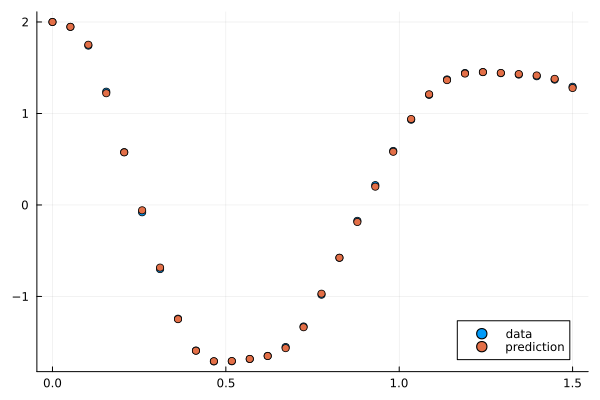

0.0048802593


UndefVarError: UndefVarError: `plt` not defined

In [11]:
callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)
scatter!(plt, tsteps, loss_neuralode(result_neuralode2.u)[2][1, :]; label = "prediction") # hide

In [ ]:
using Flux

struct SplitActivationLayer
    layer::Dense
    activation1::Function
    activation2::Function
end

function (m::SplitActivationLayer)(x)
    y = m.layer(x)
    n = size(y, 1) ÷ 2
    y1 = m.activation1(y[1:n, :])
    y2 = m.activation2(y[n+1:end, :])
    return vcat(y1, y2)
end

In [ ]:
# Define the custom layer with two different activation functions
split_activation_layer = SplitActivationLayer(Dense(10, 20), relu, sigmoid)

# Define the model using the custom layer
model = Chain(
    Dense(5, 10),
    split_activation_layer,
    Dense(20, 1)
)

# Example input
x = rand(5, 1)

# Forward pass
y = model(x)
println(y)